In [4]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from IPython import display
from matplotlib import animation, cm

from ott.geometry import pointcloud
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from lower_bound import histogram_distances

In [5]:
# Samples spiral
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


# Samples Swiss roll
def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll


# Plots spiral and Swiss roll
def plot(
    swiss_roll, spiral, colormap_angles_swiss_roll, colormap_angles_spiral
):
    fig = plt.figure(figsize=(11, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(spiral[:, 0], spiral[:, 1], c=colormap_angles_spiral)
    ax.grid()
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.view_init(7, -80)
    ax.scatter(
        swiss_roll[:, 0],
        swiss_roll[:, 1],
        swiss_roll[:, 2],
        c=colormap_angles_swiss_roll,
    )
    ax.set_adjustable("box")
    plt.show()

In [6]:
# Data parameters
n_spiral = 400
n_swiss_roll = 500
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3

In [7]:
# Seed
seed = 14
key = jax.random.PRNGKey(seed)
key, *subkey = jax.random.split(key, 4)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


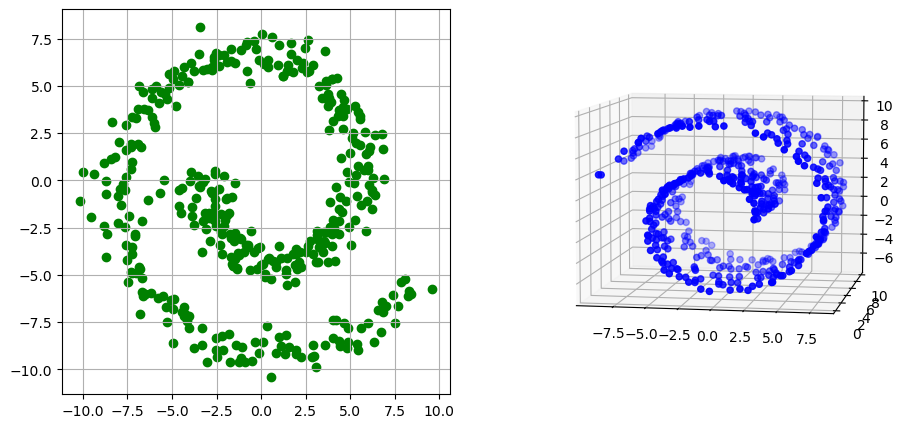

In [8]:
spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)

plot(swiss_roll, spiral, "blue", "green")

In [9]:
# apply Gromov-Wasserstein
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

solver = gromov_wasserstein.GromovWasserstein(epsilon=100.0, max_iterations=20)
out = solver(prob)

n_outer_iterations = jnp.sum(out.costs != -1)
has_converged = bool(out.linear_convergence[n_outer_iterations - 1])
print(f"{n_outer_iterations} outer iterations were needed.")
print(f"The last Sinkhorn iteration has converged: {has_converged}")
print(f"The outer loop of Gromov Wasserstein has converged: {out.converged}")
print(f"The final regularized GW cost is: {out.reg_gw_cost:.3f}")

5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 1183.614


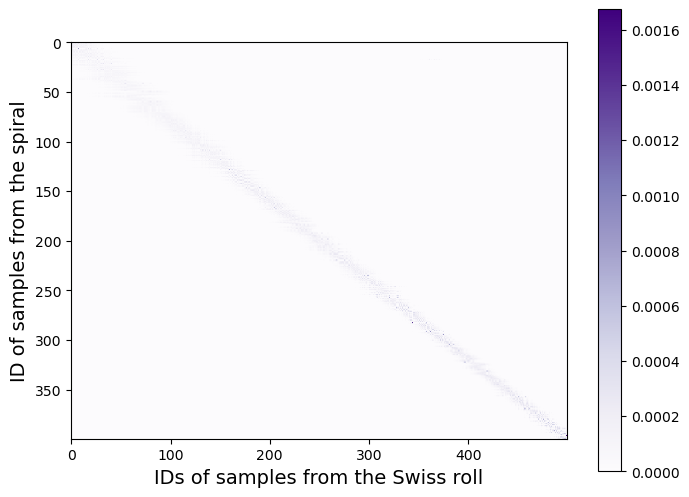

In [10]:
transport = out.matrix
fig = plt.figure(figsize=(8, 6))
plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()
plt.show()

In [11]:
# Animates the transport matrix
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "IDs of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()


# Initialization function
def init():
    im.set_data(np.zeros(transport.shape))
    return [im]


# Animation function
def animate(i):
    array = im.get_array()
    geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
    geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
    prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

    solver = gromov_wasserstein.GromovWasserstein(epsilon=i, max_iterations=20)

    out = solver(prob)

    im.set_array(out.matrix)
    im.set_clim(0, jnp.max(out.matrix[:]))
    return [im]


# Call the animator
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[70.0, 100.0, 200.0, 500.0, 750.0, 1000.0, 2000.0, 10000.0, 50000.0],
    interval=1500,
    blit=True,
)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

In [12]:
# For each sample from the spiral, we get the most coupled point from the Swiss roll
indices_swiss_roll = jnp.array(np.argmax(transport, axis=1))

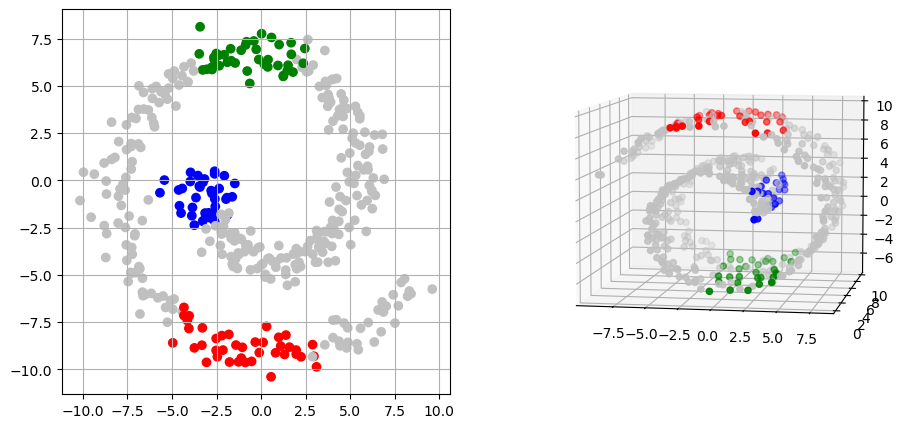

In [13]:
# Sets colors to visualise matching of some areas between each shape
# IDs of spiral and Swiss roll are ordered from center to outer part
colors_input_spiral = (
    ["b"] * 40
    + ["silver"] * 160
    + ["g"] * 40
    + ["silver"] * 90
    + ["r"] * 40
    + ["silver"] * 30
)
colors_swiss_roll = np.array(["silver"] * 500)
colors_swiss_roll[indices_swiss_roll[:40]] = "b"
colors_swiss_roll[indices_swiss_roll[200:240]] = "g"
colors_swiss_roll[indices_swiss_roll[330:370]] = "r"

plot(swiss_roll, spiral, colors_swiss_roll, colors_input_spiral)